In [1]:
import re
import numpy as np
import sys
from peft import LoraConfig, get_peft_model,PeftModel, PeftConfig
sys.path.append("/home/tsuchida/KLab_MultiModalModel/tsuchida_workdir/..")
from PIL import Image
from typing import List
import torch

/opt/conda/envs/kmmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def find_loc_index_combinations(s):  
    # 正規表現のパターンを更新: <loc_数字>の後に物体の名前も取得できるようにする
    pattern = r'<loc_(\d+)><loc_(\d+)>'
    
    # Find all matches in the given string  
    matches = re.findall(pattern, s)  
      
    valid_combinations = []  
      
    for match in matches:
        x_val, y_val = match

        valid_combinations.append((int(x_val), int(y_val)))
      
    return valid_combinations

def get_box_coords_from_index(P, ul_idx, lr_idx):  
    """  
    Given a grid of length P and the indices of the upper-left and lower-right corners of a bounding box,  
    returns the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2].  
      
    Args:  
    - P (int): the length of the grid  
    - ul_idx (int): the index of the grid cell that corresponds to the upper-left corner of the bounding box  
    - lr_idx (int): the index of the grid cell that corresponds to the lower-right corner of the bounding box  
      
    Returns:  
    - box_coords (np.array of shape (4,)): the normalized coordinates of the bounding box, in the form [x1, y1, x2, y2]  
    """  
    # Compute the size of each cell in the grid  
    cell_size = 1.0 / P  
      
    # Compute the x and y indices of the upper-left and lower-right corners of the bounding box  
    ul_x = ul_idx % P  
    ul_y = ul_idx // P  
      
    lr_x = lr_idx % P  
    lr_y = lr_idx // P  
      
    # Compute the normalized coordinates of the bounding box  
    if ul_idx == lr_idx:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    elif ul_x == lr_x or ul_y == lr_y:  
        x1 = ul_x * cell_size  
        y1 = ul_y * cell_size  
        x2 = lr_x * cell_size + cell_size  
        y2 = lr_y * cell_size + cell_size  
    else:  
        x1 = ul_x * cell_size + cell_size / 2  
        y1 = ul_y * cell_size + cell_size / 2  
        x2 = lr_x * cell_size + cell_size / 2  
        y2 = lr_y * cell_size + cell_size / 2  
      
    return np.array([x1, y1, x2, y2])

def decode_bbox_from_caption(caption, quantized_size=40, **kwargs):
    
    valid_combinations = find_loc_index_combinations(caption)
    # entity_names = list(valid_combinations)
    patch_index_coords = list(map(lambda pair: get_box_coords_from_index(quantized_size, pair[0], pair[1]), valid_combinations))
    collect_entity_location = []
    for patch_index_coord in patch_index_coords:
        collect_entity_location.append(patch_index_coord.tolist())
    
    return collect_entity_location

caption = "<loc_3><loc_1598>" 
print(find_loc_index_combinations(caption))
print(decode_bbox_from_caption(caption))



[(3, 1598)]
[[0.08750000000000001, 0.0125, 0.9625, 0.9875]]


##### 動作確認

In [4]:
if __name__ == "__main__":
    
    caption = "<loc_3><loc_1598> <loc_1><loc_1590>" 
    print(find_loc_index_combinations(caption))
    print(decode_bbox_from_caption(caption))

[(3, 1598), (1, 1590)]
[[0.08750000000000001, 0.0125, 0.9625, 0.9875], [0.037500000000000006, 0.0125, 0.7625, 0.9875]]


In [5]:
import torch
from torchvision import transforms
from PIL import Image,PngImagePlugin

# Decompressed Data Too Largeになることを防ぐ
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, resize=256):
        self.images, self.tgt_texts, self.src_texts = [], [], []
        self.src_transforms = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.tgt_transforms = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
        ])

    def __getitem__(self, idx):
        image, src_text, tgt_text = self.images[idx], self.src_texts[idx], self.tgt_texts[idx]
        image = Image.open(image).convert('RGB')
        src_image = self.src_transforms(image)
        tgt_image = self.src_transforms(image)

        return src_image, tgt_image, src_text, tgt_text
    
    def __len__(self):
        return len(self.images)


In [14]:
import os

#存在しない画像を除外するためのリスト
dropimageidlist = ["7f1934f5884fad79","429019e83c1c2c94","4f818c006da84c9e","5b86e93f8654118a","673d74b7d39741c3","6dcd3ce37a17f2be","805baf9650a12710"
                   ,"98ac2996fc46b56d","a46a248a39f2d97c"]

class OpenImageDataset_Localization(DatasetLoader):
    """openimageのdetectionデータセット
    """    
    def __init__(self,data_dir:str="/data/dataset/openimage/",phase:str="train"):
        super().__init__()        
        if phase=="val":
            phase = "validation"

        with open(os.path.join("/home/dataset/openimage","tsv_fix",f"{phase}_loc_cut_max_tokens.tsv")) as f:
            items = f.read()

        items = items.split("\n")
        items = [item.split("\t") for item in items]
        items = items[1:10]
        self.tgt_texts = [item[3] for item in items]
        self.src_texts = [f"Which regions does the text \"{item[1]}\" describe?" for item in items]
        self.images = [os.path.join(data_dir,f"{phase}_256_png",f"{item[0]}.png") for item in items]

        #dropimageidlistに含まれる画像と対応するテキストを除外する
        drop_intdexs = []
        for drop_id in dropimageidlist:
            drop_path = os.path.join(data_dir,f"{phase}_256_png",f"{drop_id}.png")
            if drop_path in self.images:
                drop_intdexs.extend([i for i,x in enumerate(self.images) if x == drop_path])
        self.tgt_texts = [x for i,x in enumerate(self.tgt_texts) if i not in drop_intdexs]
        self.src_texts = [x for i,x in enumerate(self.src_texts) if i not in drop_intdexs]
        self.images = [x for i,x in enumerate(self.images) if i not in drop_intdexs]

In [26]:
train_dataset = OpenImageDataset_Localization(data_dir="/home/dataset/openimage", phase="train")
val_dataset = OpenImageDataset_Localization(data_dir="/home/dataset/openimage",phase="val")

In [27]:
from transformers import AutoTokenizer
from torchvision import transforms
# src_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256)
src_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=512, use_fast=True)

# tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])
resize=256
src_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
])
tgt_transforms = transforms.Compose([
    transforms.Resize((resize, resize)),
    transforms.ToTensor(),
])

In [28]:
import numpy as np
def custom_to_pil(x):
  x = x.detach().cpu().numpy()
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)

  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_data(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    # tgt_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base", model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(1600)])
    tgt_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large", model_max_length=512, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(1000)] + [f"<img_{i}>" for i in range(16384)])
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        # src_text = src_tokenizer(src_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=256, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(tgt_text)
        bboxes = decode_bbox_from_caption(tgt_text)
        
        
        # 各bboxを描画
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=9, color='white')
    
        plt.axis('off')
        plt.show()
        # display(custom_to_pil(src_image[0]))

src_text: Which regions does the text "Cake" describe?
tgt_text: <loc_1060><loc_1556>


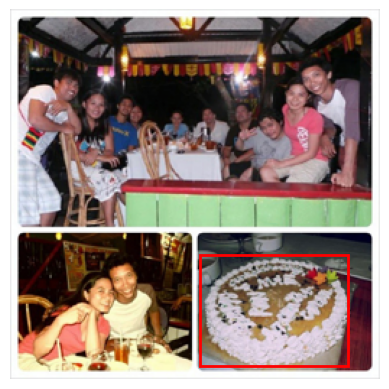

src_text: Which regions does the text "Dairy Product" describe?
tgt_text: <loc_1060><loc_1516>


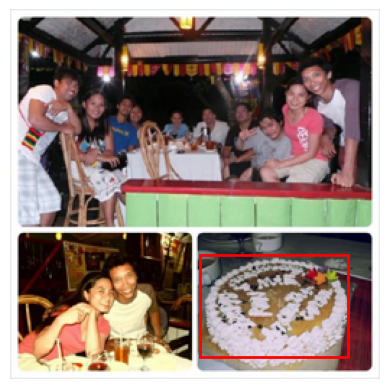

src_text: Which regions does the text "Building" describe?
tgt_text: <loc_1400><loc_1522> <loc_280><loc_1124> <loc_1402><loc_1485> <loc_1325><loc_1490> <loc_1184><loc_1558> <loc_1071><loc_1195> <loc_673><loc_1398>


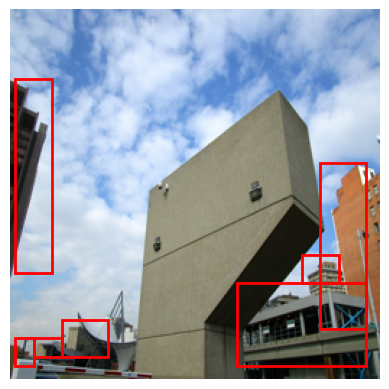

In [30]:
show_data(train_dataset, idx=0)
show_data(train_dataset, idx=1)
show_data(train_dataset, idx=5)

##### 学習したものを可視化

In [31]:
import argparse
args = argparse.Namespace(
    # Model setting
    image_model_name="microsoft/swinv2-large-patch4-window12to16-192to256-22kto1k-ft",
    image_model_train=False,
    language_model_train=False,
    language_model_name="google/flan-t5-large",
    transformer_model_name="google/flan-t5-base",
    ffn=True,
    phase = "train",
    transformer_d_model=768,
    transformer_d_ff=3072,
    # transformer_d_model=1024,
    # transformer_d_ff=4096,
    transformer_d_kv=64,
    transformer_num_heads=12,
    transformer_num_layers=2,
    transformer_num_decoder_layers=12,
    image_vocab_size=16384,
    loc_vocab_size=1600,
    vae_ckpt_path="checkpoints/vqgan.pt",
    max_source_length=512,
    max_target_length=512,
    # Train setting
    pretrain="train", 
    # Dir setting
    root_dir="/data01/",
    result_dir="results/",
    loss = "CrossEntropy",
    loc_learn = "train",
    float_type = 'bfloat16',
    lora_r = 4,
    lora_alpha = 4,
    lora_dropout = 0.1,
    lora_bias = "none",
    datasets = "openimage_loc",
    additional_vocab_size = 10000,
    stage="train"
)



In [4]:
from peft.utils.other import ModulesToSaveWrapper
class ExtendedModulesToSaveWrapper(ModulesToSaveWrapper):
    def __init__(self, module_to_save, adapter_name):
        super().__init__(module_to_save, adapter_name)
        self.main_input_name = "input_embeds" # ここでPeftModelの適切な入力名を設定する

# wrapper_instance = ExtendedModulesToSaveWrapper(module_to_save, adapter_name)     

In [33]:

from models.model_decode import MyModel
model = MyModel(args).to(device)
print(model)
tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=256, use_fast=True, extra_ids=0, additional_special_tokens =[f"<extra_id_{i}>" for i in range(100)] + [f"<loc_{i}>" for i in range(args.loc_vocab_size)] + [f"<img_{i}>" for i in range(args.image_vocab_size)])

# tgt_tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=args.max_target_length, use_fast=True, extra_ids=0, additional_special_tokens =[f"<loc_{i}>" for i in range(args.loc_vocab_size)])
# model.transformer.resize_token_embeddings(len(tgt_tokenizer))

path = "/home/tsuchida/KLab_MultiModalModel/results/loc/lora/bf16/qkv/1e-5/openimage/1e-5lambda/enc2_dec12/epoch_40.pth"
# path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/epoch_40.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/openimage/enc2_dec12/best.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/openimage/enc2_dec12/epoch_30.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/lora/1e-4/openimage/enc2_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/lora/bf16/scratch/1e-4/openimage/enc2_dec12/best.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/1e-4/openimage/enc0_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/bf16/scratch/1e-4/openimage/enc0_dec12/epoch_10.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/loc/sample/openimage/1e-5lambda/enc0_dec12/bestLora"
path = "/home/tsuchida/KLab_MultiModalModel/results/lora/vg/visual_genome_refexp/enc2_dec24/epoch_4"
path = "/home/tsuchida/KLab_MultiModalModel/results/scratch/visual_genome_refexp/enc2_dec24/epoch_2.pth"

# train
path = "/home/tsuchida/KLab_MultiModalModel/results/scratch/base/visual_genome_refexp/enc2_dec12/epoch_50.pth"
# lora
path = "/home/tsuchida/KLab_MultiModalModel/results/lora/base/vg/visual_genome_refexp/enc2_dec12/epoch_50"

path = "/home/tsuchida/KLab_MultiModalModel/results/1201/lora/2e-4/openimage_loc/enc2_dec12/epoch_50"
# path = "/home/tsuchida/KLab_MultiModalModel/results/1207/openimage_loc/enc2_dec12/epoch_40"
# path = "/home/jikuya/KLab_MultiModalModel/results/train/caption_vqa_classify/enc2_dec12/Linear50_1e-4/epoch_50.pth"
path = "/data/epoch_50.pth"
path = "/home/tsuchida/KLab_MultiModalModel/results/0111/2e-4/openimage_loc/enc2_dec12/epoch_12.pth"

if (args.loc_learn == "lora"):
    model = PeftModel.from_pretrained(model, path)
else:
    model.load(result_name=path)
# model = set_peft_model_state_dict(model, path)
# model = PeftModel.from_pretrained(model, path)
print(model)
model.eval()

MyModel(
  (language_model): T5EncoderModel(
    (shared): Embedding(32128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
                (wi_1): Line

MyModel(
  (language_model): T5EncoderModel(
    (shared): Embedding(32128, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseGatedActDense(
                (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
                (wi_1): Line

In [15]:
def calculate_iou(boxA: List[float], boxB: List[float]) -> float:
    # Compute the intersection area
    interArea = max(0, min(boxA[2], boxB[2]) - max(boxA[0], boxB[0])) * max(0, min(boxA[3], boxB[3]) - max(boxA[1], boxB[1]))
    if interArea == 0:
        print("interArea: ", interArea)
        return 0.0
    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    print("iou: ", iou)
    return iou

In [34]:
def show_result(dataset, idx=10):
    src_image, tgt_image, src_text, tgt_text = dataset[idx]
    with torch.no_grad():
        src_image = src_image.unsqueeze(0).to(device)
        tgt_text2 = tgt_text
        print('src_text:', src_text)
        print('tgt_text:', tgt_text)
        src_text = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        tgt_text = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')['input_ids'].to(device) # ['pt', 'tf', 'np', 'jax']
        # print(src_text, tgt_text)

        # display(custom_to_pil(src_image[0]))
        src_attention_masks = torch.ones_like(src_text, device=device, dtype=torch.bool)
        src_attention_masks[src_text == 0] = 0
        tgt_attention_masks = torch.ones_like(tgt_text, device=device, dtype=torch.bool)
        tgt_attention_masks[tgt_text == 0] = 0
        preds= model(src_image, src_text, src_attention_masks, tgt_text, tgt_attention_masks,return_loss=False)

        # print(loss)
        preds = tgt_tokenizer.batch_decode(preds[:,1:-1])
        print('pred:', preds[0])
        print(type(preds))
        img = custom_to_pil(src_image[0])
        
        img_width, img_height = img.size
        fig, ax = plt.subplots(1)
        ax.imshow(img)
        bboxes =[]
        find_loc_index_combinations(preds[0])
        bboxes = decode_bbox_from_caption(preds[0])
        
        tgt_box =[]
        find_loc_index_combinations(tgt_text2)
        tgt_box = decode_bbox_from_caption(tgt_text2)
        
        # 各bboxを描画
        for item in tgt_box:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = item
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='green', alpha=0.5), fontsize=9, color='white')
        
        for items in bboxes:
            # bboxの座標を実際の画像サイズにスケーリング
            x1, y1, x2, y2 = items
            x1 = x1 * img_width
            y1 = y1 * img_height
            x2 = x2 * img_width
            y2 = y2 * img_height
            width = x2 - x1
            height = y2 - y1
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
            ax.add_patch(rect)
            
            # bboxの上にラベル（物体の名前）を表示
            # plt.text(x1, y1, label, bbox=dict(facecolor='yellow', alpha=0.5), fontsize=9, color='black')
    
        # # Iterate over each prediction
        # iou_threshold = 0.5
        # gt_match_status = [False] * len(tgt_box)
        # pred_match_status = [False] * len(bboxes)
        # for pred_idx, pred_box in enumerate(bboxes):
        #     # Iterate over each ground truth
        #     for gt_idx, gt_box in enumerate(tgt_box):
                
        #         print("gt_box: ", gt_box)
        #         print("pred_box: ", pred_box)
        #         if not gt_match_status[gt_idx]:  # If this ground truth is not matched yet
        #             iou = calculate_iou(gt_box, pred_box)
        #             if iou >= iou_threshold:
        #                 # If IoU is above the threshold, it's a match
        #                 gt_match_status[gt_idx] = True
        #                 pred_match_status[pred_idx] = True
        #                 break  # No need to check other ground truths for this prediction

        # # Update TP, FP, FN based on matches found
        # tps = sum(pred_match_status)
        # fps = len(bboxes) - tps
        # fns = len(tgt_box) - tps
        # print("tps: ", tps)
        # print("fps: ", fps)
        # print("fns: ", fns)
        plt.axis('off')
        plt.show()
        # preds = src_tokenizer.batch_decode(output[:,1:-1])


src_text: Which regions does the text "Cake" describe?
tgt_text: <loc_1060><loc_1556>
pred: <loc_1060><loc_1556>
<class 'list'>
gt_box:  [0.5125, 0.6625, 0.9125, 0.9625]
pred_box:  [0.5125, 0.6625, 0.9125, 0.9625]


NameError: name 'calculate_iou' is not defined

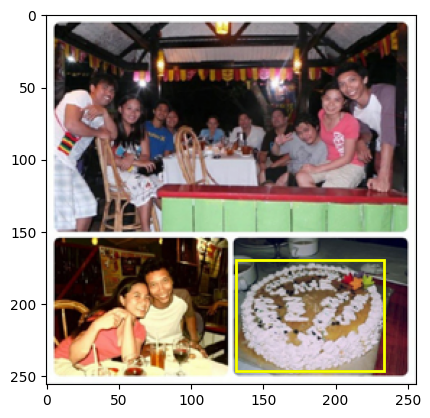

In [35]:
show_result(train_dataset, idx=0)

src_text: Which regions does the text "Cake" describe?
tgt_text: <loc_1060><loc_1556>


pred: paradise Couple particlestool<loc_9> carriage<loc_15><loc_9> Couple paradise<loc_5><loc_5><loc_22> Crawford<loc_15> carriage<loc_9><loc_5><loc_5><loc_9><loc_9> cultiv epidemi VIII epidemi<loc_9> particles Egal<loc_9><loc_9><loc_9> sèche<loc_15><loc_15>plikation<loc_9> WordPress<loc_15> paradise<loc_15> epidemi laboratories touchdown epidemi<loc_5> paradise<loc_15> imperfections<loc_9><loc_15><loc_9><loc_9> touchdown epidemi epidemi<loc_15> losing<loc_9><loc_15> touchdown VIII thick paradise<loc_15> Couple paradise<loc_5><loc_5>tool sèche<loc_15><loc_9> paradise<loc_15><loc_9><loc_16><loc_9> paradise<loc_15><loc_9><loc_22><loc_9><loc_15> foul<loc_8><loc_15> touchdown<loc_9> Couple orders Couple paradiseriz<loc_5><loc_5> epidemitool<loc_13>tool Couple<loc_5> paradise<loc_5> paradise carriage<loc_15><loc_9><loc_19><loc_5> paradise paradise<loc_5><loc_5> epidemi<loc_9><loc_19><loc_16><loc_5>tool<loc_13> Couple<loc_9>tooltool<loc_9>toolatingatingating<loc_8><loc_5><loc_5> touchdown<lo

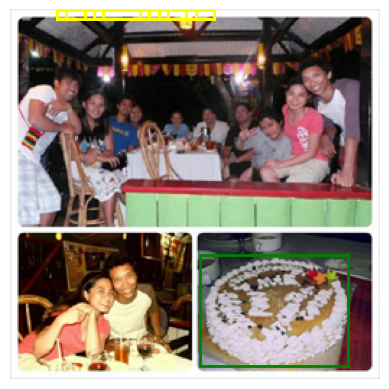

src_text: Which regions does the text "Building" describe?
tgt_text: <loc_1400><loc_1522> <loc_280><loc_1124> <loc_1402><loc_1485> <loc_1325><loc_1490> <loc_1184><loc_1558> <loc_1071><loc_1195> <loc_673><loc_1398>
pred: <loc_0><loc_25><loc_9><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_25><loc_2

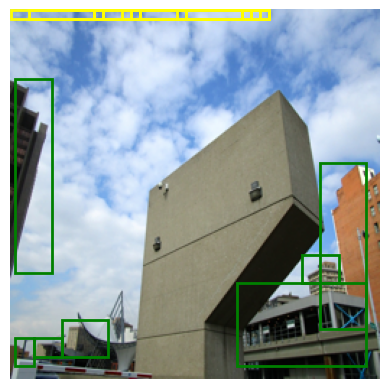

src_text: Which regions does the text "Woman" describe?
tgt_text: <loc_482><loc_1298>
pred: <loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13> fehlen<loc_13> salary<loc_13><loc_25><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13> VIII<loc_13><loc_25><loc_13><loc_13><loc_13><loc_25><loc_25><loc_13> HIGH<loc_13><loc_25><loc_13> touchdown HIGH<loc_13><loc_25><loc_13> HIGH<loc_13> VIII<loc_13> touchdown HIGH<loc_13><loc_13><loc_13> touchdown VIII<loc_13><loc_13><loc_25><loc_13><loc_13><loc_25><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_25> touchdown HIGH touchdown HIGH touchdown HIGH<loc_13><loc_13> touchdown touchdown HIGH<loc_13><loc_13><loc_13> touchdown<loc_13> Epic Epic<loc_13><loc_25> Shuttle<loc_13><loc_25> HIGH<loc_13><loc_13> Polit<loc_25><loc_25><loc_25><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13> HIGH<loc_13><loc_13> Ep

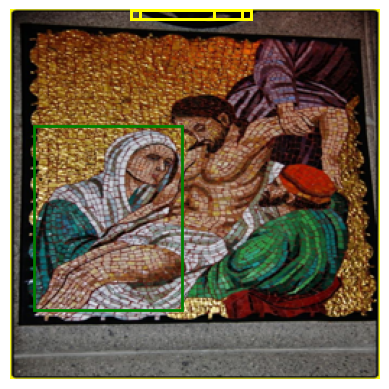

src_text: Which regions does the text "Building" describe?
tgt_text: <loc_240><loc_1169> <loc_848><loc_1054> <loc_583><loc_1198>
pred: <loc_14><loc_13><loc_9> vaguezione<loc_0><loc_14><loc_9><loc_13><loc_14><loc_9> wakenduzione<loc_14><loc_9>çoçouddleasia<loc_14>ço<loc_9> residentialuddlezione<loc_22><loc_14><loc_9><loc_9><loc_9><loc_9><loc_9><loc_14> triple promoted<extra_id_11>studie insultzione<loc_9> wakeçonormal residential<loc_13> carriage<loc_14> angeboten<loc_14>asia promoted<loc_9> risks carburant<loc_9> angeboten<loc_14>zione<loc_4><loc_9>cronço touchdownzukünftigdoch carburant Gestalt<loc_24> wake wake<loc_14>zione<loc_14><loc_14> Handels aventur<loc_9><loc_24> Handels residential<loc_9><loc_9> dezbatere carriage Egalcronuddle<loc_18> ihrecronuddle<loc_18>cron wake carriage Egal ihreyanayanaço<loc_9><loc_9> dezbaterecron<loc_14>cron action<loc_14> Weltyana<loc_14> Faith<loc_9><loc_14><loc_9><loc_9><loc_9><loc_9> angeboten<loc_14><loc_14> Handels Couple<loc_14>nduuddle carria

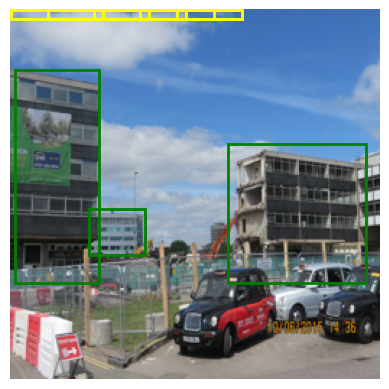

src_text: Which regions does the text "Fixed-wing aircraft" describe?
tgt_text: <loc_80><loc_1277>
pred: <loc_18><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_24><loc_13><loc_24><loc_19><loc_13><loc_10><loc_13><loc_13><loc_24><loc_19><loc_13><loc_19><loc_10><loc_13><loc_13><loc_24><loc_19><loc_13><loc_10><loc_10><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13

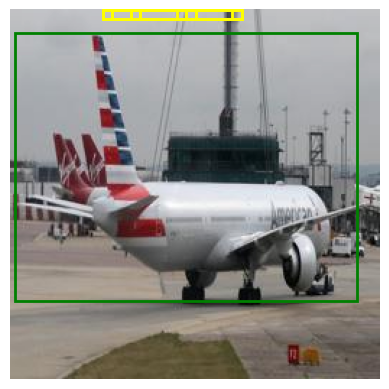

src_text: Which regions does the text "Food" describe?
tgt_text: <loc_0><loc_1599>
pred: <loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13><loc_13

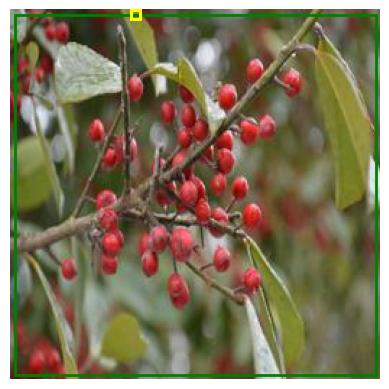

src_text: Which regions does the text "Human arm" describe?
tgt_text: <loc_360><loc_564> <loc_166><loc_330> <loc_92><loc_258> <loc_100><loc_345> <loc_308><loc_675> <loc_874><loc_1277>
pred: <loc_13><loc_14> function<loc_22><loc_13><loc_13> function<loc_13><loc_13><loc_13><loc_13> HIGH<loc_22><loc_13><loc_13><loc_22><loc_22> Faith<loc_13><loc_13> function function<loc_13><loc_13><loc_22><loc_13><loc_13> function<loc_22><loc_22><loc_13><loc_13><loc_22><loc_13><loc_22><loc_13> function<loc_13><loc_13><loc_9><loc_13> function function<loc_13><loc_13> function<loc_22><loc_13> function<loc_13><loc_13> function<loc_22><loc_22><loc_13><loc_13><loc_13><loc_22><loc_13><loc_13><loc_22><loc_22><loc_22><loc_13><loc_22><loc_22> responsible function<loc_22><loc_25><loc_18><loc_13><loc_22><loc_22><loc_13><loc_22> function<loc_13><loc_14> function Egal<loc_13><loc_22><loc_13><loc_13><loc_22><loc_22><loc_18><loc_13>IR<loc_14><loc_13><loc_13><loc_13><loc_22><loc_13><loc_13><loc_13><loc_22><loc_13><loc_22

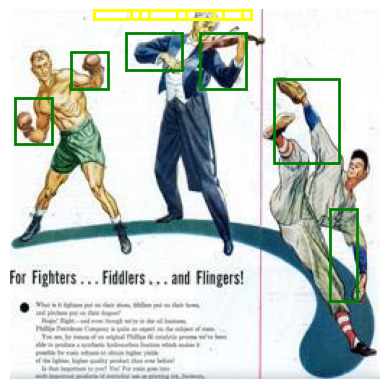

src_text: Which regions does the text "Human body" describe?
tgt_text: <loc_160><loc_1012> <loc_12><loc_1025> <loc_306><loc_1478>
pred: IR VIII<loc_22><loc_22><loc_22><loc_9><loc_25><loc_22><loc_22><loc_13><loc_13><loc_22><loc_22><loc_22><loc_22><loc_13><loc_13><loc_9><loc_22> Egal<loc_22><loc_22><loc_13><loc_22><loc_22><loc_22><loc_22><loc_22> function<loc_22><loc_22> function<loc_13><loc_13><loc_22><loc_22><loc_22><loc_22><loc_13><loc_22><loc_22><loc_22><loc_13><loc_22><loc_13><loc_13><loc_22><loc_25><loc_22><loc_13><loc_13><loc_13><loc_22> function<loc_22> VIII<loc_9><loc_22><loc_13><loc_13><loc_22> function<loc_22> Egal<loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_22><loc_13><loc_22><loc_13><loc_13><loc_22><loc_13><loc_9><loc_13><loc_22><loc_5><loc_13><loc_22><loc_13><loc_13><loc_13><loc_13><loc_22> function<loc_22><loc_13><loc_22><loc_13><loc_22><loc_22><loc_22><loc_22><loc_5><loc_25><loc_13><loc_22><loc_25><loc_13><loc_22> responsibl

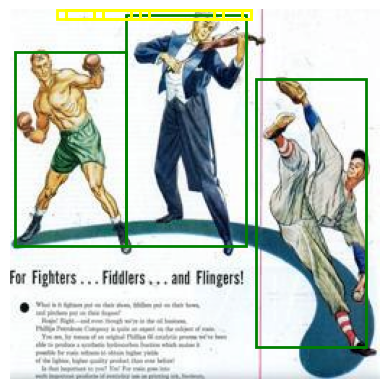

In [18]:
show_result(train_dataset, idx=0)
# show_result(train_dataset, idx=1)
show_result(train_dataset, idx=5)
show_result(train_dataset, idx=6)
show_result(train_dataset, idx=7)
show_result(val_dataset, idx=0)
show_result(val_dataset, idx=1)
show_result(val_dataset, idx=5)
show_result(val_dataset, idx=6)

In [19]:
src_tokenizer.encode('Whale')

[30300, 1]

In [14]:
from scipy.optimize import linear_sum_assignment
def compute_iou(bbox1: list, bbox2: list, verbose: bool=False):
    x1,y1,x2,y2 = bbox1
    x1_,y1_,x2_,y2_ = bbox2
    
    x1_in = max(x1,x1_)
    y1_in = max(y1,y1_)
    x2_in = min(x2,x2_)
    y2_in = min(y2,y2_)

    intersection = compute_area(bbox=[x1_in,y1_in,x2_in,y2_in],invalid=0.0)
    area1 = compute_area(bbox1,invalid=0)
    area2 = compute_area(bbox2,invalid=0)
    union = area1 + area2 - intersection
    iou = intersection / (union + 1e-6)

    if verbose:
        return iou, intersection, union

    return iou 


def compute_area(bbox: list, invalid: float=None) -> float:
    x1,y1,x2,y2 = bbox

    if (x2 <= x1) or (y2 <= y1):
        area = invalid
    else:
        area = (x2 - x1) * (y2 - y1)

    return area


def assign_boxes(pred_boxes: list[list], gt_boxes: list[list]):
    n1 = len(pred_boxes)
    n2 = len(gt_boxes)
    cost = np.zeros([n1,n2])
    ious = np.zeros([n1,n2])
    for i,bbox1 in enumerate(pred_boxes):
        for j,bbox2 in enumerate(gt_boxes):
            iou = compute_iou(bbox1,bbox2)
            ious[i,j] = iou
            cost[i,j] = 1-iou

    # solve assignment
    pred_box_ids, gt_box_ids = linear_sum_assignment(cost)
    pair_ids = list(zip(pred_box_ids, gt_box_ids))

    # select assignments with iou > 0
    pair_ids = [(i,j) for i,j in pair_ids if ious[i,j] > 0]
    pairs = [(pred_boxes[i],gt_boxes[j]) for i,j in pair_ids]
    pair_ious = [ious[i,j] for i,j in pair_ids]

    return pairs, pair_ious, pair_ids


def loc_metric(pred_boxes: list[list], gt_boxes: list[list]) -> float:
    num_pred = len(pred_boxes)
    num_gt = len(gt_boxes)
    if num_pred == 0 and num_gt == 0:
        return 1
    elif min(num_pred,num_gt) == 0 and max(num_pred,num_gt) > 0:
        return 0
        
    pairs, pair_ious, pair_ids = assign_boxes(pred_boxes,gt_boxes)
    num_detected = len(pairs)
    num_missed = num_gt - num_detected
    return np.sum(pair_ious) / (num_pred + num_missed)


In [19]:
from data import *
from modules import *
from modules.acc import *
from modules.utils import *
import random
from tqdm import tqdm

# model.eval()
print(f'done')

dataset = get_dataset(args, dataset_name=args.datasets[0], phase=args.data_phase)
dataloader = get_dataloader(args, dataset, num_workers=4, shuffle=False)
random.seed(999)
torch.manual_seed(999)
gts = []
prs = []

total_precision = 0.0  # Total True Positives across all images
total_recall = 0.0  # Total False Positives across all images
total_f = 0.0  # Total False Negatives across all images
num = 0
acc_array = []
iou_threshold = 0.5  # IoU threshold for a prediction to be considered correct
for src_image, tgt_images, src_text, tgt_text in tqdm(dataloader):
    with torch.no_grad():
        tgt_text2 = tgt_text
        src_images = src_image.to(device, non_blocking=True)
        # if args.phase == 'pretrain':
        #    tgt_images = tgt_images.to(device)
        #    tgt_texts, _ = model.module.image_to_z(tgt_images)
        if args.phase == 'classify':
            src_inputs = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt') # ['pt', 'tf', 'np', 'jax']
            src_texts = src_inputs['input_ids'].to(device, non_blocking=True)
            tgt_texts = tgt_texts.to(device, non_blocking=True)
            tgt_attention_masks = None
        else:
            src_inputs = src_tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt') # ['pt', 'tf', 'np', 'jax']
            src_texts = src_inputs['input_ids'].to(device, non_blocking=True)
            src_texts = src_texts.to(device, non_blocking=True)
            tgt_inputs = tgt_tokenizer(tgt_text, padding="longest", max_length=args.max_target_length, return_tensors='pt')
            tgt_texts = tgt_inputs['input_ids'].to(device, non_blocking=True)
            tgt_texts = tgt_texts.to(device, non_blocking=True)
            tgt_attention_masks = torch.ones_like(tgt_texts, device=device, dtype=torch.bool)
            tgt_attention_masks[tgt_texts == 0] = 0
        src_attention_masks = torch.ones_like(src_texts, device=device, dtype=torch.bool)
        src_attention_masks[src_texts == 0] = 0
        
        preds = model(src_images, src_texts, src_attention_masks, tgt_texts, tgt_attention_masks,return_loss = False)
        
        # 予測の取得
        preds = tgt_tokenizer.batch_decode(preds[:, 1:-1])
        cleaned_preds = []
        prs = []
        for pred in preds:
            # '</s>'が現れる位置を見つけます
            end_pos = pred.find('</s>')
            # '</s>'が見つかった場合、その位置までの文字列を保持します
            if end_pos != -1:
                pred = pred[:end_pos]

            # '<pad>'を削除します
            pred = pred.replace('<pad>', '')

            cleaned_preds.append(pred.strip())  # 空白を削除してリストに追加します
        prs.extend(cleaned_preds)

        # print('tgt_text:', tgt_text2)
        # print('pred:', prs)

        # バッチ状態から1つずつ予測と正解を取り出す
        for tgt_bbox, pred_bbox in zip(tgt_text2, prs):
            # 1枚の画像に対する正解値と予測値を座標のリストに変換
            tgt_bboxes = decode_bbox_from_caption(tgt_bbox)
            # print("tgt_bboxes: ", tgt_bboxes)
            pred_bboxes = decode_bbox_from_caption(pred_bbox)
            
            # print(float(loc_metric(pred_bboxes,tgt_bboxes)))
            acc_array.append(float(loc_metric(pred_bboxes,tgt_bboxes)))

            
            # # gt_match_status = [False] * len(tgt_bboxes)
            # # pred_match_status = [False] * len(pred_bboxes)
            # # 予測と正解のすべての組み合わせに対してIoUを計算
            # for pred_idx, pred_box in enumerate(pred_bboxes):
            #     # Iterate over each ground truth
            #     for gt_idx, gt_box in enumerate(tgt_bboxes):
                    
            #         # print("gt_box: ", gt_box)
            #         # print("pred_box: ", pred_box)
            #         if not gt_match_status[gt_idx]:  # If this ground truth is not matched yet
            #             iou = calculate_iou(gt_box, pred_box)
            #             if iou >= iou_threshold:
            #                 # If IoU is above the threshold, it's a match
            #                 gt_match_status[gt_idx] = True
            #                 pred_match_status[pred_idx] = True
            #                 break  # No need to check other ground truths for this prediction

            # # Update TP, FP, FN based on matches found
            # tps = sum(pred_match_status)
            # fps = len(pred_bboxes) - tps
            # fns = len(tgt_bboxes) - tps
            # print("tps: ", tps)
            # print("fps: ", fps)
            # print("fns: ", fns)

            # # 1枚につき適合率・再現率・F値を計算
            # precision = tps / (tps + fps) if (tps + fps) > 0 else 0
            # recall = tps / (tps + fns) if (tps + fns) > 0 else 0
            # f = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0  

            # total_precision += precision
            # total_recall += recall
            # total_f += f
            num += 1

print("localize_acc:",np.mean(acc_array))

done


AttributeError: 'Namespace' object has no attribute 'data_phase'